<a href="https://colab.research.google.com/github/gibeom92/dispersion_PINN/blob/master/1D_dispersion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

!pip install --upgrade pyDOE

Requirement already up-to-date: pyDOE in /usr/local/lib/python3.7/dist-packages (0.3.8)


In [12]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from pyDOE import lhs
from scipy.interpolate import griddata
import time

np.random.seed(1234)
tf.random.set_seed(1234)

In [13]:
N_C = 10000   # No. of Optimization input (B.C, I.C) 
N_f = 30000   # No. of Optimization input (f function)
layers = [2, 64,64,64,64,64,64,64,64,64, 1]   # NN config/ 2 input, 1 output
wind = 5    # u
K = 5

In [14]:
# Training input

x = np.arange(-10.0, 10.0, 0.0001)
t = np.arange(0, 0.1, 0.0001)
X, T = np.meshgrid(x, t)

C_0 = 1 / np.cosh(10*x)   # initial condition

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
lb = X_star.min(0); ub = X_star.max(0)
C_star = C_0.flatten()[:,None]

# Optimization input (f function)
# I.C
xx1 = np.hstack((X[0:1, :].T, T[0:1, :].T))
CC1 = C_0.flatten()[:,None]
# B.C 1
xx2 = np.hstack((X[:, 0:1], T[:, 0:1]))
xx2[:,0] = -8
CC2 = (np.random.uniform(size=len(t)) * 1.0e-100).flatten()[:,None]
# B.C 2
xx3 = np.hstack((X[:, -1:], T[:, -1:]))
xx3[:,0] = 8
CC3 = (np.random.uniform(size=len(t)) * 1.0e-100).flatten()[:,None]

X_C_train = np.vstack([xx1, xx2, xx3])
X_f_train = lb + (ub - lb) * lhs(2, N_f)    # Optimization input (f function)
X_f_train = np.vstack((X_f_train, X_C_train))
C_train = np.vstack([CC1, CC2, CC3])

idx = np.random.choice(X_C_train.shape[0], N_C, replace=False)
X_C_train = X_C_train[idx, :]
C_train = C_train[idx, :]

In [15]:
class PINN:
  def __init__(self, X_C, C, X_f, layers, lb, ub, wind, K):

    self.dtype = tf.float32
    self.count = 0

    self.x_C = tf.convert_to_tensor(X_C[:,0:1], dtype=self.dtype)
    self.t_C = tf.convert_to_tensor(X_C[:,1:2], dtype=self.dtype)

    self.x_f = tf.convert_to_tensor(X_f[:,0:1], dtype=self.dtype)   # (n, 1) shape으로 나옴
    self.t_f = tf.convert_to_tensor(X_f[:,1:2], dtype=self.dtype)

    self.C = tf.convert_to_tensor(C, dtype=self.dtype) 

    self.sizes_w = []
    self.sizes_b = []
    for i, width in enumerate(layers):
      if i != 1:
        self.sizes_w.append(int(width * layers[1]))
        self.sizes_b.append(int(width if i != 0 else layers[1]))

    # neural network
    self.C_model = tf.keras.Sequential()
    self.C_model.add(tf.keras.layers.InputLayer(input_shape=(layers[0],)))
    self.C_model.add(tf.keras.layers.Lambda(lambda X: 2.0 * (X - lb)/(ub - lb) - 1.0))
    for node in layers[1:-2]:
      self.C_model.add(tf.keras.layers.Dense(node, activation = 'tanh', 
                                             kernel_initializer = 'glorot_normal'))  # glorot: xavier initializer
    for node in layers[-2:]:
      self.C_model.add(tf.keras.layers.Dense(node, activation = 'sigmoid', 
                                             kernel_initializer = 'glorot_normal', 
                                             bias_constraint = tf.keras.constraints.NonNeg()))

  # network for C / C_pred / C_0 와 비교
  def net_C(self):
    X_C = tf.stack([self.x_C, self.t_C], axis=1)
    C = self.C_model(X_C)
    return C

  # Calculate f / PDE
  def net_f(self):
    with tf.GradientTape(persistent = True) as tape:   # persistent = False
      tape.watch(self.x_f)
      tape.watch(self.t_f)
      X_f = tf.stack([self.x_f, self.t_f], axis=1)
      
      C = self.C_model(X_f)
      C_t = tape.gradient(C, self.t_f)
      C_x = tape.gradient(C, self.x_f)
      C_xx = tape.gradient(C_x, self.x_f)

    del tape
    return C_t + wind * C_x - K * C_xx

  # Loss
  @tf.function    # get_weight, set_weight 가 tf.function 에서 안됨
  def loss(self):
    f_pred = self.net_f()
    C_pred = self.net_C()
    return tf.reduce_mean(tf.square(self.C - C_pred)) + tf.reduce_mean(tf.square(f_pred))

  def get_weights(self):
    w = []
    for layer in self.C_model.layers[1:]:
      weights_biases = layer.get_weights()
      weights = weights_biases[0].flatten()
      biases = weights_biases[1]
      w.extend(weights)
      w.extend(biases)
    return tf.convert_to_tensor(w, dtype=self.dtype)

  def set_weights(self, w):   # weight update를 위한 함수
    for i, layer in enumerate(self.C_model.layers[1:]):
      start_weights = sum(self.sizes_w[:i]) + sum(self.sizes_b[:i])
      end_weights = sum(self.sizes_w[:i+1]) + sum(self.sizes_b[:i])
      weights = w[start_weights:end_weights]
      w_div = int(self.sizes_w[i] / self.sizes_b[i])
      weights = tf.reshape(weights, [w_div, self.sizes_b[i]])
      biases = w[end_weights:end_weights + self.sizes_b[i]]
      weights_biases = [weights, biases]
      layer.set_weights(weights_biases)

  def step(self):
    self.count += 1
    return self.count

  def train(self):
    def optim(w):
      with tf.GradientTape() as tape:
        self.set_weights(w)
        loss = self.loss()
      grad = tape.gradient(loss, self.C_model.trainable_variables)
      grad_flat = []
      for g in grad:
        grad_flat.append(tf.reshape(g, [-1]))
      grad_flat = tf.concat(grad_flat, 0)
      self.step()
      if self.count % 100 == 0:
        print(self.count, ': ', loss)
      return loss, grad_flat

    return tfp.optimizer.lbfgs_minimize(
        optim, self.get_weights(),
        num_correction_pairs = 50, 
        max_iterations = 5000, 
        parallel_iterations = 256)


In [18]:
# Training

model = PINN(X_C_train, C_train, X_f_train, layers, lb, ub, wind, K)

with tf.device('/gpu:0'):
  start_time = time.time()
  result = model.train()    # training
  elapsed = time.time() - start_time
  print('time: ', elapsed)

100 :  tf.Tensor(0.008683021, shape=(), dtype=float32)
200 :  tf.Tensor(0.00654687, shape=(), dtype=float32)
300 :  tf.Tensor(0.00531536, shape=(), dtype=float32)
400 :  tf.Tensor(0.0046348004, shape=(), dtype=float32)
500 :  tf.Tensor(0.0040699746, shape=(), dtype=float32)
600 :  tf.Tensor(0.0035207204, shape=(), dtype=float32)
700 :  tf.Tensor(0.0035122777, shape=(), dtype=float32)
800 :  tf.Tensor(0.0028448983, shape=(), dtype=float32)
900 :  tf.Tensor(0.0027477816, shape=(), dtype=float32)
1000 :  tf.Tensor(0.0023408316, shape=(), dtype=float32)
1100 :  tf.Tensor(0.0022569695, shape=(), dtype=float32)
1200 :  tf.Tensor(0.0019937642, shape=(), dtype=float32)
1300 :  tf.Tensor(0.0018938048, shape=(), dtype=float32)
1400 :  tf.Tensor(0.0017928015, shape=(), dtype=float32)
1500 :  tf.Tensor(0.0016737501, shape=(), dtype=float32)
1600 :  tf.Tensor(0.0015731883, shape=(), dtype=float32)
1700 :  tf.Tensor(0.0014656575, shape=(), dtype=float32)
1800 :  tf.Tensor(0.001418941, shape=(), dtyp

In [19]:
# Test

dx = 0.1
x = np.arange(-10.0, 10.0, dx)
dt = 0.01
t = np.arange(0, 0.1, dt)
X, T = np.meshgrid(x, t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

C_pred = model.C_model(X_star)
result = griddata(X_star, C_pred, (X, T), method='cubic')

In [20]:
C_0 = 1 / np.cosh(10*x)

In [ ]:
np.shape(result[0])

(200, 1)

In [ ]:
result[0] = np.reshape(C_0,(200,1))

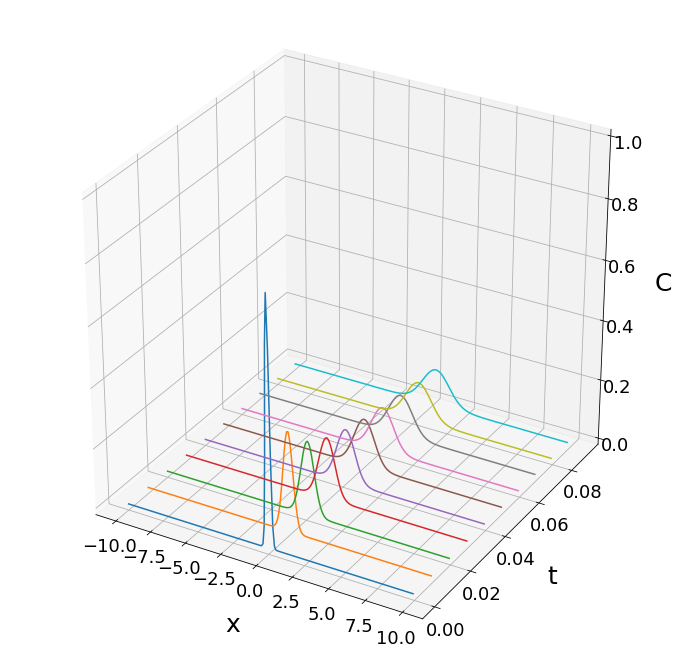

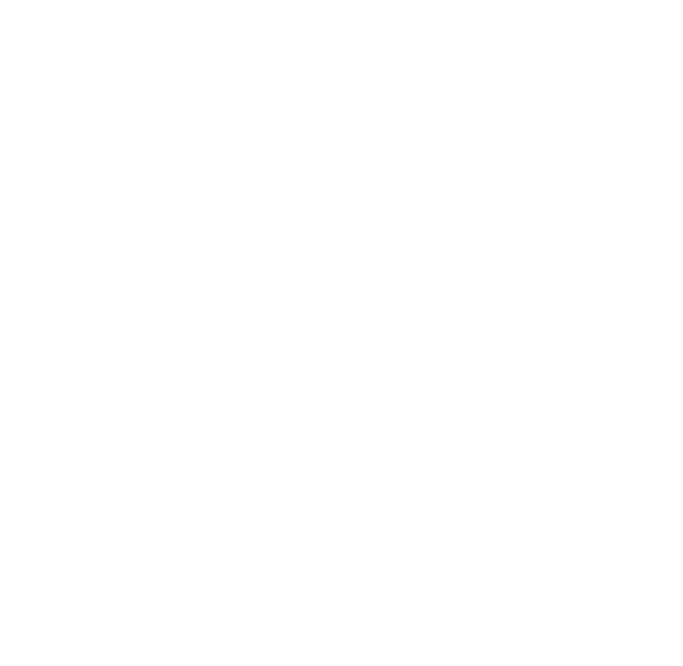

In [20]:
plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams.update({'font.size': 18})
fsize = 25

# Waterfall plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlim3d(0, 1)

C_plot = np.reshape(result,(10,200))
for j in range(C_plot.shape[0]):
    ys = j * np.ones(C_plot.shape[1]) * dt
    ax.plot(x, ys, C_plot[j, :])
    ax.set_xlabel('x', size=fsize, labelpad=20)                                
    ax.set_ylabel('t', size=fsize, labelpad=20)                            
    ax.set_zlabel('C', size=fsize, labelpad=20)  

# Image plot
plt.figure()
#plt.imshow(np.flipud(u), aspect=8)
plt.axis('off')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

df = pd.DataFrame(C_plot)
df.to_excel(excel_writer='/content/drive/My Drive/Colab Notebooks/Dispersion/PINN2.xlsx')